In [1]:
!pip install -q diffusers

In [2]:
# imports
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
from diffusers import UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

c:\Users\user\OneDrive\Desktop\ALL\Code\Coding project\genai\Gen-AI-DL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
# pixel art dataset loader.
class PixelArtDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

        # Data Validation (more comprehensive)
        if self.images.shape[1:] != (16, 16, 3):  # Check image size (16x16x3)
            raise ValueError(f"Images must be 16x16x3, but are {self.images.shape}")
        if self.labels.ndim != 2 or self.labels.shape[1] != 5:  # Check label shape
            raise ValueError(f"Labels must be a 2D array with 5 elements per row, but are {self.labels.shape}")
        if self.images.shape[0] != self.labels.shape[0]:
            raise ValueError("Number of images and labels must match")
        if self.images.dtype != np.uint8:  # Check data type. Assuming your images are 8-bit
            raise TypeError(f"Images must be uint8, but are {self.images.dtype}. Convert if necessary")
        if self.labels.dtype != np.float64:  # Check data type. Assuming your labels are float32
            raise TypeError(f"Labels must be float32, but are {self.labels.dtype}. Convert if necessary")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image to tensor, normalize, and add channel dimension
        image = torch.from_numpy(image).float() / 255.0  # Normalize to [0, 1]

        # No need to unsqueeze for RGB images:
        image = image.permute(2, 0, 1) # Change from HxWx3 to 3xHxW (CHW)

        if self.transform:
            image = self.transform(image)

        label = torch.from_numpy(label).float()

        return image, label

In [4]:
images_path = "../npy_dataset/sprites.npy"
labels_path = "../npy_dataset/sprites_labels.npy"

transform = transforms.Compose([

])

dataset = PixelArtDataset(images_path, labels_path, transform=transform)

# Create a DataLoader for batching and shuffling
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)  # Adjust batch size as needed

Input shape: torch.Size([8, 3, 16, 16])


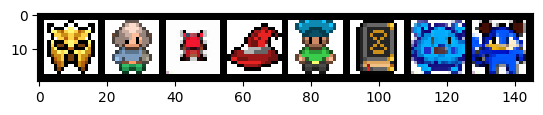

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt

# ... (Your dataset and dataloader setup)

x, y = next(iter(dataloader))
print('Input shape:', x.shape)  # Should be (batch_size, channels, height, width)
# print('Labels:', y)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # CHW to HWC
    plt.show()

# Display the grid of images (all images in the batch)
imshow(torchvision.utils.make_grid(x))

In [5]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

In [6]:
# Create the network
net = UNet2DModel(
    sample_size=16,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
    ),   
)
net.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [7]:
n_epochs = 100
batch_size = 512
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 
losses = []

for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.079951
Finished epoch 1. Average loss for this epoch: 0.042265
Finished epoch 2. Average loss for this epoch: 0.036043
Finished epoch 3. Average loss for this epoch: 0.032355
Finished epoch 4. Average loss for this epoch: 0.030838
Finished epoch 5. Average loss for this epoch: 0.029320
Finished epoch 6. Average loss for this epoch: 0.027981
Finished epoch 7. Average loss for this epoch: 0.027354
Finished epoch 8. Average loss for this epoch: 0.026663
Finished epoch 9. Average loss for this epoch: 0.025666
Finished epoch 10. Average loss for this epoch: 0.025368
Finished epoch 11. Average loss for this epoch: 0.024728
Finished epoch 12. Average loss for this epoch: 0.024159
Finished epoch 13. Average loss for this epoch: 0.023787
Finished epoch 14. Average loss for this epoch: 0.022956
Finished epoch 15. Average loss for this epoch: 0.022183
Finished epoch 16. Average loss for this epoch: 0.021380
Finished epoch 17. Average loss for this 

Text(0.5, 1.0, 'Loss over time')

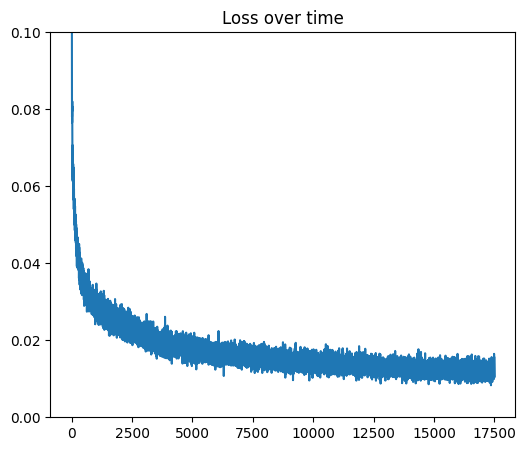

In [8]:
# plot the loss over time.
fig, axs = plt.subplots(1, 1, figsize=(6, 5))

axs.plot(losses)
axs.set_ylim(0, 0.1)
axs.set_title('Loss over time')

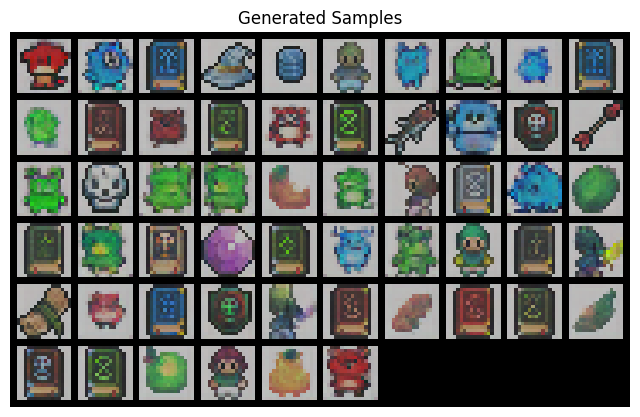

In [9]:
# Samples
n_steps = 40
x = torch.rand(56, 3, 16, 16).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# Convert for display
grid_img = torchvision.utils.make_grid(x.detach().cpu(), nrow=10, normalize=True).permute(1, 2, 0).numpy()

# Display
axs.imshow(grid_img)  # No cmap needed for RGB
axs.set_title('Generated Samples')
axs.axis("off")

plt.show()